<a href="https://www.kaggle.com/code/aniruddhapa/named-entity-recognition-v1-2?scriptVersionId=140225833" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

<a href="https://colab.research.google.com/github/aniruddhapal/NLP-Named-Entity-Recognition-/blob/main/Named_Entity_Recognition_v1_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Named Entity Recognition (NER) with LSTM-CRF: Extracting Insights from Text Data

**Description:**

Unlock the power of natural language processing (NLP) with this comprehensive Kaggle notebook focused on Named Entity Recognition (NER) using LSTM-CRF architecture. In the world of text analysis, extracting valuable information from unstructured text data is crucial for a wide range of applications, from information retrieval to sentiment analysis.

## Notebook Highlights:

**Understanding NER:** Delve into the fundamentals of Named Entity Recognition, a pivotal NLP task that involves identifying and categorizing entities such as names, locations, organizations, and more within a text.

**LSTM-CRF Architecture:** Explore the cutting-edge combination of Long Short-Term Memory (LSTM) and Conditional Random Fields (CRF), known as LSTM-CRF, that outperforms traditional methods in capturing context and label dependencies.

**Data Preprocessing:** Learn how to preprocess text data, tokenize sentences, and prepare them for LSTM-CRF input.

**Feature Engineering:** Dive into feature extraction techniques that help the model capture relevant information within sentences, enabling accurate entity recognition.

**Model Implementation:** Step through the implementation of the LSTM-CRF architecture, understand how to set up the layers, and fine-tune hyperparameters for optimal performance.

**Training and Evaluation:** Train the LSTM-CRF model on labeled data, explore evaluation metrics to measure model accuracy, and gain insights into its performance.

**Real-Life Applications:** Discover real-life scenarios where NER plays a pivotal role, such as information retrieval, recommendation systems, and more.

**Hands-On Practice:** Apply the knowledge gained to practical examples, showcasing your ability to extract entities from text data and enhance your NLP skills.

Whether you're a data science enthusiast, NLP practitioner, or looking to elevate your skills in text analysis, this notebook provides a comprehensive guide to harnessing the potential of LSTM-CRF for advanced Named Entity Recognition. Join us on this journey to unveil hidden insights within text and empower your data-driven decision-making.

*Note: This notebook is designed for educational purposes and offers hands-on experience in implementing an LSTM-CRF model for NER. Feel free to explore, experiment, and adapt the techniques to your specific NLP projects and applications.*

In [1]:
#import the required packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from keras.utils.vis_utils import plot_model
from numpy.random import seed
from itertools import chain
from tensorflow.keras import Model,Input
from tensorflow.keras.layers import LSTM,Embedding,Dense
from tensorflow.keras.layers import TimeDistributed, SpatialDropout1D,Bidirectional
plt.style.use('seaborn')

In [2]:
data=pd.read_csv('../input/ner-dataset/ner_datasetreference.csv',encoding='unicode_escape')
data.head()

,Sentence #,Word,POS,Tag
0,Sentence: 1,Thousands,NNS,O
1,NaN,of,IN,O
2,NaN,demonstrators,NNS,O
3,NaN,have,VBP,O
4,NaN,marched,VBN,O


In [3]:
#Delete the POS column as we do not need it
data.drop('POS',axis='columns',inplace=True)

In [4]:
data.head(15)

,Sentence #,Word,Tag
0,Sentence: 1,Thousands,O
1,NaN,of,O
2,NaN,demonstrators,O
3,NaN,have,O
4,NaN,marched,O
5,NaN,through,O
6,NaN,London,B-geo
7,NaN,to,O
8,NaN,protest,O
9,NaN,the,O


In [5]:
#NaN values to be filled using Forward Fill method.
data=data.fillna(method='ffill')

In [6]:
data.head(35)

,Sentence #,Word,Tag
0,Sentence: 1,Thousands,O
1,Sentence: 1,of,O
2,Sentence: 1,demonstrators,O
3,Sentence: 1,have,O
4,Sentence: 1,marched,O
5,Sentence: 1,through,O
6,Sentence: 1,London,B-geo
7,Sentence: 1,to,O
8,Sentence: 1,protest,O
9,Sentence: 1,the,O


In [7]:
'''Extracting unique values from the 'Word' column of the DataFrame data. It is using the set() function 
to create a set of unique words and then converting that set back into a list. So, the variable words 
will contain a list of unique words found in the 'Word' column of the DataFrame.'''

words=list(set(data['Word'].values))

'''Adding the string "ENDPAD" to the end of the words list. The term "ENDPAD" is often used in natural 
language processing tasks, such as sequence labeling, to indicate the end of a sequence. It's a common 
practice to have a special token like this in NLP tasks.'''

words.append("ENDPAD")

''' Accessing the last element of the words list, which is now "ENDPAD". By using the index -1, referencing the last element in the list.'''
words[-1]

'ENDPAD'

In [8]:
words[-10:]

['firmn',
 'asylum-seeker',
 'cooperative',
 'snowbank',
 'insolent',
 'contractions',
 'mutation',
 '4.7',
 'ZUMA',
 'ENDPAD']

In [9]:
#Total no. of words
num_words=len(data['Word'])
print("Total number of words",num_words)

Total number of words 1048575


In [10]:
#List of Tags and total no. of Tags
tags = list(set(data["Tag"].values))
num_tags = len(tags)
num_tags
print("List of tags: " + ', '.join([tag for tag in tags]))
print(f"Total Number of tags {num_tags}")

List of tags: B-geo, I-org, I-art, I-eve, I-nat, I-geo, B-art, I-per, I-gpe, B-org, B-nat, B-per, B-tim, O, B-gpe, B-eve, I-tim
Total Number of tags 17


In [11]:
data.head()

,Sentence #,Word,Tag
0,Sentence: 1,Thousands,O
1,Sentence: 1,of,O
2,Sentence: 1,demonstrators,O
3,Sentence: 1,have,O
4,Sentence: 1,marched,O


In [12]:
#Creating a class which will give the complete sentence with Tags attached with each word
class Get_sentence(object):
  def __init__(self,data):
    self.n_sent=1 #keeps track of the sentences
    self.data=data
    
    '''This lambda function takes a group s (a subset of the input data) and aggregates the 'Word' and 'Tag' 
    columns from that group into a list of tuples.'''
    
    agg_func=lambda s:[(w,t) for w,t in zip(s['Word'].tolist(),s['Tag'].tolist())]
    
    '''This line groups the input data by the 'Sentence #' column and applies the agg_func lambda function 
    to each group. It creates a new DataFrame with the aggregated results, where each row represents a 
    sentence with associated words and tags.'''
    
    self.grouped=self.data.groupby('Sentence #').apply(agg_func)
    
    '''This line converts the grouped data into a list of sentences, where each sentence is represented as a
    list of tuples containing words and tags.'''
    
    self.sentences=[s for s in self.grouped]

In [13]:
getter=Get_sentence(data)
sentence=getter.sentences

In [14]:
print(type(sentence))

<class 'list'>


In [15]:
#Each sentence is a list of tuples containing words and tags
sentence[0]

[('Thousands', 'O'),
 ('of', 'O'),
 ('demonstrators', 'O'),
 ('have', 'O'),
 ('marched', 'O'),
 ('through', 'O'),
 ('London', 'B-geo'),
 ('to', 'O'),
 ('protest', 'O'),
 ('the', 'O'),
 ('war', 'O'),
 ('in', 'O'),
 ('Iraq', 'B-geo'),
 ('and', 'O'),
 ('demand', 'O'),
 ('the', 'O'),
 ('withdrawal', 'O'),
 ('of', 'O'),
 ('British', 'B-gpe'),
 ('troops', 'O'),
 ('from', 'O'),
 ('that', 'O'),
 ('country', 'O'),
 ('.', 'O')]

In [16]:
### Data Visualizaion

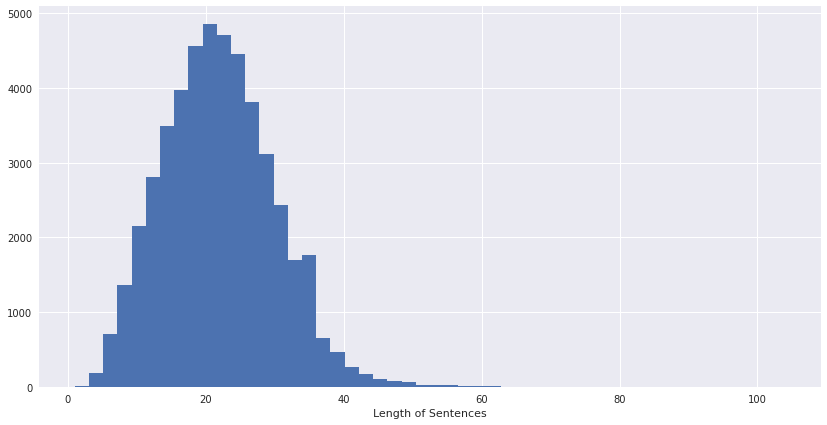

In [17]:
plt.figure(figsize=(14,7))
plt.hist([len(s) for s in sentence],bins = 50)
plt.xlabel("Length of Sentences")
plt.show()

In [18]:
# most of our sentenses have a length of 20 words, the longest sentense is around 63 words



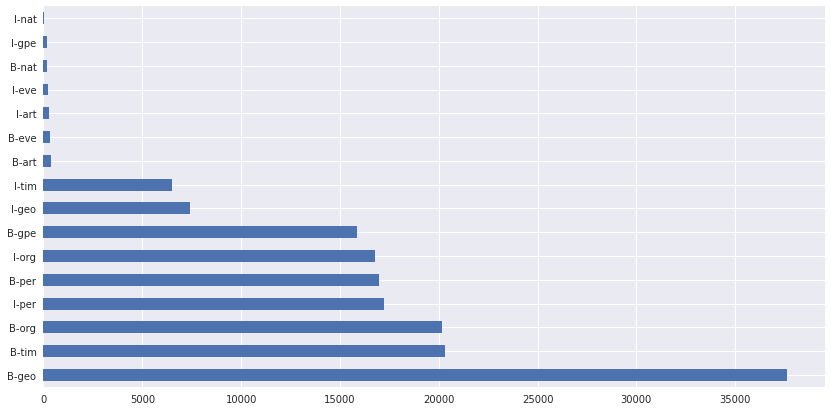

In [19]:
plt.figure(figsize=(14, 7))
data.Tag[data.Tag != 'O']\
    .value_counts()\
    .plot\
    .barh();

In [20]:
## We can understand from the bar chart above that B-geo Tags are over-represented. 
## I-nat and I-gpe Tags are negligible and almost non-existent. Model will have difficulty in classifying these 2 tags.

In [21]:
# Data Preparation

# Mapping words and tags to their corresponding indices

Creating 2 dictionaries word_idx and tag_idx to to establish mappings between words/tags and their corresponding indices.

The word_idx dictionary maps words to indices, and the tag_idx dictionary maps tags to indices, allowing easy conversion between words/tags and their corresponding indices.

In [22]:
word_idx = {w : i + 1 for i ,w in enumerate(words)}
tag_idx =  {t : i for i ,t in enumerate(tags)}

In [23]:
len(tag_idx)

17

# Sentence Preprocessing and Transformation

preprocessing the sentences and tags, converting words and tags into numerical indices, and padding the sequences to a fixed length of 50 for consistent input to a machine learning model.

In [24]:
word_idx['PAD']=0

In [25]:
# Padding our sentences using max lenght of 50.
max_len=50
padding_value = word_idx['PAD']
X=[[word_idx[w[0]] for w in s] for s in sentence]
X=pad_sequences(maxlen=max_len,sequences=X,padding='post',value=padding_value)
y=[[tag_idx[w[1]]for w in s]for s in sentence]
y=pad_sequences(maxlen=max_len,sequences=y,padding='post',value=tag_idx['O'])


In [26]:
# 1st sentence's numerical representation mapped with the respective indices
X[0]

array([29753,  2024, 21739,   904,  1770,  1431, 10057, 18605, 23247,
       11378, 19556, 32819, 15984, 13354, 28518, 11378, 11815,  2024,
       14853, 26547, 32380, 21442, 23651, 34206,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0], dtype=int32)

In [27]:
# 1st sentence's tag representation, numerically mapped with respective tag indices
y[0]

array([13, 13, 13, 13, 13, 13,  0, 13, 13, 13, 13, 13,  0, 13, 13, 13, 13,
       13, 14, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13,
       13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13],
      dtype=int32)

# Converting numerical tag indices into one-hot encoded vectors.

In [28]:
y=[to_categorical(i,num_classes=num_tags) for i in y]

In [29]:
num_tags

17

In [30]:
y[0]

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
        0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
        0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
        0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
        0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
        0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
        0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
        0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
        0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
        0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
        0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0

In [31]:
# Split the data using Train Test split.
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.1,random_state=1)

# LSTM-based Bidirectional Recurrent Neural Network

> This code creates a Bidirectional LSTM-based neural network model with an embedding layer, dropout, and dense output layer with softmax activation for sequence labeling tasks like Named Entity Recognition. It's designed to take sequences of words as input and predict a sequence of tag labels for each word in the input sequence.

In [32]:
'''This line creates an input layer for the neural network with a shape of (max_len,), 
where max_len represents the maximum length of the input sequences (sentences).'''

input_word=Input(shape=(max_len,))

'''This line adds an embedding layer to the model. It converts the input word indices into dense 
vectors of a specified output_dim dimension. input_dim represents the total number of unique words in the 
vocabulary, and input_length specifies the length of each input sequence.'''

model=Embedding(input_dim=num_words,output_dim=max_len,input_length=max_len)(input_word)

'''This line adds a 1D spatial dropout layer to the model. Spatial dropout drops entire 1D feature maps 
instead of individual elements, which helps to regularize the network by preventing overfitting. 
The dropout rate is set to 0.1, which means 10% of the features will be dropped during training.'''

model=SpatialDropout1D(0.1)(model)

'''Here, a Bidirectional LSTM layer is added. This layer allows the model to learn from both the past and 
future context of the input sequence. The units parameter sets the number of LSTM units/neurons in each 
direction, and return_sequences=True ensures that the output of this layer is a sequence 
(important for sequence labeling tasks). recurrent_dropout introduces dropout in the recurrent 
connections to prevent overfitting.'''

model=Bidirectional(LSTM(units=100,return_sequences=True,recurrent_dropout=0.1))(model)

'''TimeDistributed wrapper is applied to a Dense layer, which produces an output for each time step of 
the sequence. This is necessary for sequence labeling tasks. The Dense layer's output size is num_tags, 
representing the number of unique tag classes, and the activation function is softmax, which is common 
for multi-class classification problems.'''

out=TimeDistributed(Dense(num_tags,activation='softmax'))(model)


model=Model(input_word,out)

'''The model is compiled with the Adam optimizer, categorical cross-entropy loss 
(suitable for multi-class classification), and accuracy as the evaluation metric.'''

model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 50)]              0         
_________________________________________________________________
embedding (Embedding)        (None, 50, 50)            52428750  
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 50, 50)            0         
_________________________________________________________________
bidirectional (Bidirectional (None, 50, 200)           120800    
_________________________________________________________________
time_distributed (TimeDistri (None, 50, 17)            3417      
Total params: 52,552,967
Trainable params: 52,552,967
Non-trainable params: 0
_________________________________________________________________


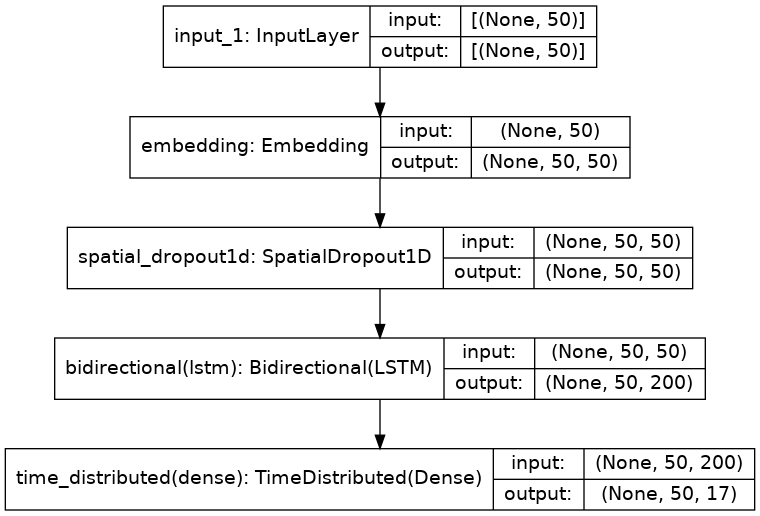

In [33]:
plot_model(model,show_shapes=True)

In [34]:
#Training the model with Training data
model.fit(X_train,np.array(y_train),batch_size=64,verbose=1,epochs=3,validation_split=0.2)

Epoch 1/3
540/540 [==============================] - 504s 924ms/step - loss: 0.5291 - accuracy: 0.9244 - val_loss: 0.1156 - val_accuracy: 0.9667
Epoch 2/3
540/540 [==============================] - 499s 923ms/step - loss: 0.0879 - accuracy: 0.9754 - val_loss: 0.0591 - val_accuracy: 0.9827
Epoch 3/3
540/540 [==============================] - 497s 920ms/step - loss: 0.0477 - accuracy: 0.9862 - val_loss: 0.0513 - val_accuracy: 0.9844


# Model Evaluation

In [35]:
model.evaluate(X_test,np.array(y_test))

150/150 [==============================] - 2s 17ms/step - loss: 0.0537 - accuracy: 0.9841


[0.05372731015086174, 0.9840867519378662]

# Model Prediction with Test set


In [36]:
rand_sent=np.random.randint(0,X_test.shape[0])
print('randam sentence',rand_sent)
p=model.predict(np.array([X_test[rand_sent]]))
#print('prediction:',p)
p=np.argmax(p,axis=-1)
print(p[0])

y_true=np.argmax(np.array(y_test),axis=-1)[rand_sent]

print("{:20}{:20}\t{}\n".format("Word","True","Pred"))
print("-"*55)

for (w,t,pred)in zip(X_test[rand_sent],y_true,p[0]):
    print("{:20}{:20}\t{}".format(words[w-1],tags[t],tags[pred]))

randam sentence 275
[13 13 13 13 13 13 13 13  0 13 12 13 13 13 13 13 13 13 13 13 13 13 13 13
 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13
 13 13]
Word                True                	Pred

-------------------------------------------------------
The                 O                   	O
country             O                   	O
's                  O                   	O
first               O                   	O
deepwater           O                   	O
port                O                   	O
opened              O                   	O
near                O                   	O
Nouakchott          B-geo               	B-geo
in                  O                   	O
1986                B-tim               	B-tim
.                   O                   	O
ENDPAD              O                   	O
ENDPAD              O                   	O
ENDPAD              O                   	O
ENDPAD              O                   	O
ENDPAD              O      